Input directory is:  /media/ab/data/Research_Data/enhancerGC/Out2/
Output directory is:  /media/ab/data/Research_Data/enhancerGC/Out2/
/media/ab/data/Research_Data/enhancerGC/Out2/
SRR014287-1_divergent_classifications.NonGene.2Kb.fasta.bedgraph


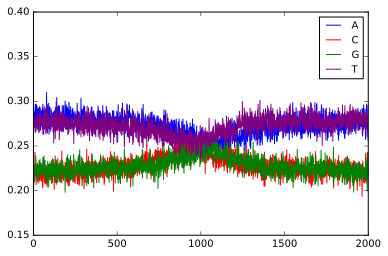

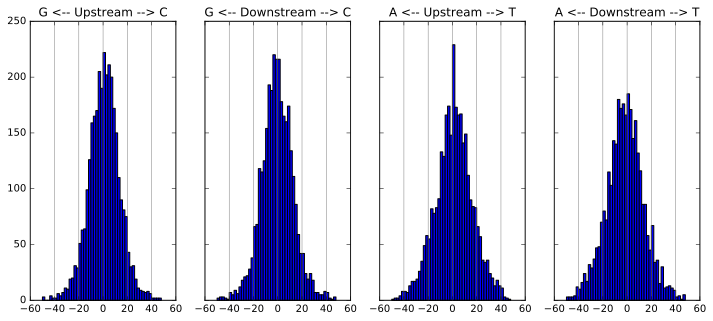

3150 3150 3150 3150 3150
 
0.00196 x + 0.1434
 
0.006469 x + 0.139
 
0.00178 x + 0.1436
 
-8.036e-05 x + 0.1415
 
-0.002578 x + 0.1434
 
-0.002808 x + 0.1441
 
0.008695 x + 0.1538
 
-0.01138 x + 0.1539
 
0.001787 x + 0.1449


SystemExit: 

/media/ab/data/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import csv
#from pybedtools import BedTool
#import pybedtools
from scipy.stats import gaussian_kde
#from scipy.stats import zscore
#pybedtools.set_tempdir('./')
#from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#GENES = "/media/ab/data/Research_Data/Genomes/hg19.refseqTSS.2kb.bed"
#GENOME = "/media/ab/data/Research_Data/Genomes/hg19.fa"
#WINDOW = 2000

def main():  
    
    ### Set up the directories and the gene file
    file_filter = ".NonGene.2Kb.fasta.bedgraph"
    #file_filter = "SRR014287-1_divergent_classifications.TSS.2Kb.fasta.bedgraph"
    INPUT_DIR = '/media/ab/data/Research_Data/enhancerGC/Out2/'
    OUTPUT_DIR = '/media/ab/data/Research_Data/enhancerGC/Out2/'

    if INPUT_DIR[-1] != '/':
        INPUT_DIR = INPUT_DIR + '/'
    #OUTPUT_DIR = createOutputFolder(OUTPUT_DIR+'OUT_'+str(D)+'_'+str(MIN_N)+'/')
    if OUTPUT_DIR[-1] != '/':
        OUTPUT_DIR = OUTPUT_DIR + '/'
    print "Input directory is: ", INPUT_DIR
    print "Output directory is: ", OUTPUT_DIR
    
    ### Open the bed files 
    DIR_LIST = sorted(os.listdir(INPUT_DIR))
    
    ### Loop through the files     
    for FILENAME in DIR_LIST:
        if FILENAME[-(len(file_filter)):] == file_filter:      ### Load only the TSV files
            SEQDATA, DATA2 = loadFromFile(INPUT_DIR+FILENAME)
            BASEDATA = getBaseData(SEQDATA)
            PROBDATA =  getProbData(BASEDATA)
            SKEWDATA = getSkewData(SEQDATA)
            makeGCATPlots(OUTPUT_DIR, FILENAME, PROBDATA[0],PROBDATA[1],PROBDATA[2],PROBDATA[3])
            makeSkewPlots(OUTPUT_DIR, FILENAME, SKEWDATA[0], SKEWDATA[1], SKEWDATA[2], SKEWDATA[3])
            makeSkewCorrScatter(OUTPUT_DIR, FILENAME, SKEWDATA[0], SKEWDATA[1], SKEWDATA[2], SKEWDATA[3], DATA2)
            #print BASEDATA[1][1]
            #print PROBDATA
    return None
    ### End of function

def loadFromFile(fileToOpen):    
    ### Extracts the fasta sequence from the raw data
    fastaColumn = 4
    aColumn = 5
    x=openFile(fileToOpen)   ### Open the file
    data = []                ### Initiate the data list
    adata = []
    for line in x:               ### For each line in the file x
        if line[0] == '#':
            continue
        #print line.strip('\n').split('\t')
        data.append(line.strip('\n').split('\t')[fastaColumn])
        adata.append(float(line.strip('\n').split('\t')[aColumn]))        
    return data, adata
    ### End of function

def openFile(fileName):     
    ### Opens the file with sequence data
    data = open(fileName)
    return data
    ### End of function    

def getSkewData(SEQDATA):
    ### Finds the base frequency at each position relative to the BTE
    length = findMaxLength(SEQDATA)
    n = len(SEQDATA)
    
    USCG = [0]*n
    DSCG = [0]*n
    USAT = [0]*n
    DSAT = [0]*n
    
    middle = int(0.5 * length)
    midDist = 500

    for i in range(n):
        USCG[i] = getSkewRatio(SEQDATA[i],'c','g',middle-midDist,middle)
        DSCG[i] = getSkewRatio(SEQDATA[i],'c','g',middle,middle+midDist)
        USAT[i] = getSkewRatio(SEQDATA[i],'a','t',middle-midDist,middle)
        DSAT[i] = getSkewRatio(SEQDATA[i],'a','t',middle,middle+midDist)
    return [USCG,DSCG,USAT,DSAT]
    ### End of function   
    
def getSkewRatio(SEQUENCE,N,D,START,END):
    
    numerator = SEQUENCE[START:END].count(N)+SEQUENCE[START:END].count(N.upper())
    denominator = SEQUENCE[START:END].count(D)+SEQUENCE[START:END].count(D.upper())
    output = ((float(numerator-denominator)/(numerator+denominator))*100)               
    #print numerator, denominator, output
    '''
    try:
        
    except ZeroDivisionError:
        data = 0
        print "Divide by Zero"'''
    return output
    
def getBaseData(SEQDATA):
    ### Finds the base frequency at each position relative to the BTE
    length = findMaxLength(SEQDATA)
    A = [0]*length
    C = [0]*length
    G = [0]*length
    T = [0]*length
    P = [0]*length
    
    BTE = 0
    
    for i in SEQDATA:
        for j in range(length):
            if i[j].upper() == 'A':
                A[j] = A[j] + 1
            if i[j].upper() == 'C':
                C[j] = C[j] + 1
            if i[j].upper() == 'G':
                G[j] = G[j] + 1
            if i[j].upper() == 'T':
                T[j] = T[j] + 1
            P[j] = P[j] + 1
        BTE += 1
    
    return [BTE,A,C,G,T,P]
    ### End of function    

def getProbData(BASEDATA):
    ### Calculate the probabilities at each base
    length = len(BASEDATA[1])
    A = [0]*length
    C = [0]*length
    G = [0]*length
    T = [0]*length
    
    for i in range(length):
        A[i] = round(int(BASEDATA[1][i]) / float(BASEDATA[5][i]), 4)
        C[i] = round(int(BASEDATA[2][i]) / float(BASEDATA[5][i]), 4)
        G[i] = round(int(BASEDATA[3][i]) / float(BASEDATA[5][i]), 4)
        T[i] = round(int(BASEDATA[4][i]) / float(BASEDATA[5][i]), 4)
    
    return [A,C,G,T]
    ### End of function        

def findMaxLength(SEQDATA):
    ### Finds the maximum length of the sequences
    MAX = 0
    for i in SEQDATA:
        if len(i) > MAX:
            MAX = len(i)
    return MAX
    ### End of function    

def createOutputFolder(new_folder):

    # Checks to see if a directory exists, and if not, makes the directory. It
    # returns the directory path as output

    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    return new_folder

def getLog(X):
    
    if X > 0:
        return np.log10(X)
    elif X < 0:
        return (-1 * (np.log10(X*-1)))
    else:
        return 0

def makeSkewPlots(OUTDIR, FILENAME, USCG, DSCG, USAT, DSAT):
    
    n = len(USCG)
    bins = range(-50,50,2)
    
    fig, (axe1, axe2, axe3, axe4) = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
    
    axe1.hist(USCG, bins)
    axe1.xaxis.grid(True, which="major", linestyle='-', color='grey')
    axe1.set_title("G <-- Upstream --> C")
    axe2.hist(DSCG, bins)
    axe2.xaxis.grid(True, which="major", linestyle='-', color='grey')
    axe2.set_title("G <-- Downstream --> C")
    axe3.hist(USAT, bins)
    axe3.xaxis.grid(True, which="major", linestyle='-', color='grey')
    axe3.set_title("A <-- Upstream --> T")
    axe4.hist(DSAT, bins)
    axe4.xaxis.grid(True, which="major", linestyle='-', color='grey')
    axe4.set_title("A <-- Downstream --> T")
    plt.savefig(OUTDIR+FILENAME+".SkewHist.png",format='png')
    plt.show()

def makeSkewCorrScatter(OUTDIR, FILENAME, USCG, DSCG, USAT, DSAT, Y):
    
    #print Y
    #n = len(USCG)
    #bins = range(-100,100,5)
    #Y = [np.log(10*x) for x in Y]
    USCG = [getLog(x) for x in USCG]
    DSCG = [getLog(x) for x in DSCG]
    USAT = [getLog(x) for x in USAT]
    DSAT = [getLog(x) for x in DSAT]
    
    xy = np.vstack([USCG,Y])
    USCG_C = gaussian_kde(xy)(xy)
    xy = np.vstack([DSCG,Y])
    DSCG_C = gaussian_kde(xy)(xy)
    xy = np.vstack([USAT,Y])
    USAT_C = gaussian_kde(xy)(xy)
    xy = np.vstack([DSAT,Y])
    DSAT_C = gaussian_kde(xy)(xy)
    
    '''
    #print(results.summary())    
    #fig, ax = plt.subplots(figsize=(8,6))
    #ax.plot(x, y, 'o', label="data")
    #ax.plot(x, y_true, 'b-', label="True")
    results = sm.OLS(Y, USCG).fit()
    prstd, iv_l, iv_u = wls_prediction_std(results)
    ax.plot(USCG, res.fittedvalues, 'r--.', label="OLS")
    ax.plot(USCG, iv_u, 'r--')
    ax.plot(USCG, iv_l, 'r--')
    ax.legend(loc='best');

    '''
    print len(USCG), len(DSCG), len(USAT), len(DSAT), len(Y)
    print np.poly1d(np.polyfit(USCG, Y, 1))
    fig, (axe1, axe2, axe3, axe4) = plt.subplots(4, 1, figsize=(8, 18), sharex=True)    
    axe1.scatter(USCG, Y, c=USCG_C)
    axe1.set_title("G <-- Upstream --> C")
    addLinRegress(axe1, USCG, Y, "+")
    addLinRegress(axe1, USCG, Y, "-")
    axe2.scatter(DSCG, Y, c=DSCG_C)
    axe2.set_title("G <-- Downstream --> C")
    addLinRegress(axe2, DSCG, Y, "+")
    addLinRegress(axe2, DSCG, Y, "-")
    axe3.scatter(USAT, Y, c=USAT_C)
    axe3.set_title("A <-- Upstream --> T")
    addLinRegress(axe3, USAT, Y, "+")
    addLinRegress(axe3, USAT, Y, "-")
    axe4.scatter(DSAT, Y, c=DSAT_C)
    axe4.set_title("A <-- Downstream --> T")
    addLinRegress(axe4, DSAT, Y, "+")
    addLinRegress(axe4, DSAT, Y, "-")
    plt.savefig(OUTDIR+FILENAME+".SkewCorr.png",format='png')
    plt.show()
    ### End of Function

def addLinRegress(axis, X, Y, Val):
    
    newX = []
    newY = []
    length = range(len(X))
    if Val == "+":
        for i in length:
            if X[i] > 0:
                newX.append(X[i])
                newY.append(Y[i])
    elif Val == "-":
        for i in length:
            if X[i] < 0:
                newX.append(X[i])
                newY.append(Y[i])
                
    axis.plot(newX, np.poly1d(np.polyfit(newX, newY, 1))(newX))
    print np.poly1d(np.polyfit(newX, newY, 1))
    return None
    
def makeGCATPlots(OUTDIR, FILENAME, A, C, G, T):
    
    print OUTDIR
    print FILENAME
    #print A
    #print C
    #print G
    #print T
    
    POSITIONS = 2000
    
    x = range(0,POSITIONS,1)
    #print x
    
    fig, ax = plt.subplots(figsize=(6, 4))
    #ax=plt.gca()
    plt.plot(x, A, color='blue', label='A')
    plt.plot(x, C, color='red', label='C')
    plt.plot(x, G, color='green', label='G')
    plt.plot(x, T, color='purple', label='T')
    plt.legend(loc="best",fontsize=10)
    plt.xlim(xmin=0, xmax=2000)
    plt.ylim(ymin=0.15, ymax=0.40)
    #plt.legend(frameon=True,ncol=1,handlelength=1)
    plt.savefig(OUTDIR+FILENAME+".ACTG.png",format='png')
    plt.show()

    
    '''
    ### Create the figure and subplot positions
    fig = plt.plot(figsize=(10, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    
    ### Plot the variance in axes 1
    ax1.plot(xNum, yVariance)  # Plot the variance data
    ax1.xaxis.tick_top()
    ax1.set_ylabel('Variance by position')
    ax1.set_ylim(bottom=0, top=.5)   
    ax1.set_xlim(left=0, right=N) 
    
    ### Plot the distribution of pi values in axes 2
    for xe, ye in zip(xNum, y):
        ax2.scatter([xe] * len(ye), ye, s=1)     # Zip the data together and plot scatters
    ax2.set_xticks(xNum)            
    ax2.set_yticks(range(-1,2,1))
    ax2.set_xticklabels(x, rotation="vertical", fontsize=8, ha="left")
    ax2.set_ylim(bottom=-1, top=1)   
    ax2.set_xlim(left=-1, right=N)   
    ax2.yaxis.grid(True, which="major", linestyle='-', color='grey')
    ax2.set_ylabel('Pi (-1 to 1)')

    ### Finalize the plot
    fig.suptitle(filename+"  N="+str(N), y=0.98, fontsize=12)
    plt.subplots_adjust(wspace=0, hspace=0.1)    
    
    ### Set the plots and show
    plt.savefig(directory+filename+".svg",format='svg')
    plt.savefig(directory+filename+".png",format='png')'''

def saveDataToText(directory, name, data):

    # Save the line data to an output text file in the same directory as the graphs

    # Create writer
    ofile  = open(directory+name, "wb")
    writer = csv.writer(ofile, delimiter='\t')
    
    # Write each line
    for line in data:
        outLine = []
        for i in line:
            outLine.append(i)
        writer.writerow(outLine)

    # Close the file
    ofile.close()
    return            
    ### End of function


if __name__ == "__main__":
    sys.exit(main())

In [59]:
a = 'ASDASDFAtalskjdtoaslAAtkhklaaaaaaaaaaaaaaaASDASDklasAAAdlkfkaaaaaaaaaaaaaalasdfjATASDAlalasdfhkallt'
a[:19].count('A')+a[:49].count('a')
a[:19].count('A','a')

TypeError: slice indices must be integers or None or have an __index__ method

In [54]:
N = 'a'
print N
print N.upper()

a
A


In [73]:
print range(0,100,10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


In [111]:
y = [1.949, 69394.49929, 2949.39994, 30029.29292, 203]
print [np.log10(x) for x in y]

[0.28981183911762148, 4.8413250464969453, 3.4697336670781529, 4.4775451062729887, 2.307496037913213]


In [102]:
x = 5
X = 38
print x, X

5 38


In [18]:
a = [3,4,5,6,7,8,3,2,7]
b = [24,6,3,63,6,7,3,2,7]
np.polyfit(a,b,1)

array([ 1.22222222,  7.33333333])

In [24]:
a = 1
b = "test"
print b+a

TypeError: cannot concatenate 'str' and 'int' objects